In [1]:
!rm -rf /kaggle/working/multimodal-eq-sizing
!git clone https://github.com/brianrp09232000/multimodal-eq-sizing.git /kaggle/working/multimodal-eq-sizing
!pip install -r /kaggle/working/multimodal-eq-sizing/requirements.txt

Cloning into '/kaggle/working/multimodal-eq-sizing'...
remote: Enumerating objects: 904, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 904 (delta 163), reused 108 (delta 101), pack-reused 675 (from 3)
Receiving objects: 100% (904/904), 1.68 MiB | 14.95 MiB/s, done.
Resolving deltas: 100% (555/555), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.9 MB/s eta 0:00:0000:0

# Modules

In [2]:
import sys
import pathlib

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import os

In [3]:
start_time = datetime.now()

In [4]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [5]:
# Uses the current directory where the notebook is running
repo_root = pathlib.Path("multimodal-eq-sizing")
sys.path.append(str(repo_root.resolve())) # .resolve() gets the full absolute path locally

In [6]:
from src.models import price_mlp 
from src.models.price_mlp import rmse, summarize_price_model_diagnostics
from src.models.price_mlp import select_feature_columns, scale_features, create_sliding_windows_single_stock
from src.models.price_mlp import split_single_stock, build_panel_dataset
from src.utils.cv import make_yearly_walkforward_splits, generate_yearly_oof, _train_predict_year

2025-12-10 18:27:52.214884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765391272.677412      79 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765391272.808371      79 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Read Data

In [7]:
df = pd.read_pickle("/kaggle/input/nasdaq-news/proc_multimodal_eq_sizing_dataset.pkl")

# Configurations

In [8]:
################# Configurations #######################
DATA_PATH  = "/kaggle/working/final_dataset.csv"   
DATE_COL   = "Date"                    
TICKER_COL = "ticker"                  
TARGET_COL = 'next_day_excess_return'             

FEATURE_COLS = [
 #'mom_rank',
 'spy_r1',
 'o2c_return',
 'excess_return',
 'VIX_Close',
 'VIX_z',
 'spread_z',
 'dollar_volume',
 'adv_dollar',
   # 'mom_12_1',
 'next_day_excess_return' ]

WINDOW_SIZE = 30        
TEST_RATIO  = 0.20      
VAL_RATIO   = 0.10      

BATCH_SIZE   = 64
EPOCHS       = 30
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.2
GRU_UNITS    = 128
LSTM_UNITS   = 128
DENSE_UNITS  = 64

# Select Feature Columns

In [9]:
def select_feature_columns(df: pd.DataFrame):
    """
    Decide which features to use：
    - if FEATURE_COLS is not None，use this function；
    - o/w use all numerical cols，excluding Date and ticker
    """
    global FEATURE_COLS

    if FEATURE_COLS is not None:
        missing = [c for c in FEATURE_COLS if c not in df.columns]
        if len(missing) > 0:
            raise ValueError(f"FEATURE_COLS is not in the dataset: {missing}")
    else:
        exclude_cols = {DATE_COL, TICKER_COL}
        FEATURE_COLS = [
            c for c in df.columns
            if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])
        ]
        print("Auto selected FEATURE_COLS:", FEATURE_COLS)

    if TARGET_COL not in FEATURE_COLS:
        raise ValueError(
            f"TARGET_COL='{TARGET_COL}'must included in the FEATURE_COLS，"
        )

    return FEATURE_COLS

In [10]:
feature_cols = select_feature_columns(df) 

# Split Data

In [11]:
def split_data_on_year(df, DATE_COL, train_year_start, train_year_end, val_year, test_year):

    # split by date
    df_train = df[df[DATE_COL] >= str(train_year_start)+'-01-01']
    df_train = df_train[df_train[DATE_COL] <= str(train_year_end)+'-12-31']
    df_val = df[df[DATE_COL] >= str(val_year)+'-01-01']
    df_val = df_val[df_val[DATE_COL] <= str(val_year)+'-12-31']
    df_test = df[df[DATE_COL] >= str(test_year)+'-01-01']
    df_test = df_test[df_test[DATE_COL] < str(test_year)+'-12-31']

    return df_train, df_val, df_test

# create X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
def create_numpy_data_type(df_train, df_val, df_test, feature_cols, TARGET_COL):

    
    y_train = np.array(df_train[TARGET_COL])
    y_val = np.array(df_val[TARGET_COL])#.dropna())
    y_test = np.array(df_test[TARGET_COL])#.dropna())
    
    model_input_cols = feature_cols.copy()
    model_input_cols.remove(TARGET_COL)

    X_train = np.array(df_train[model_input_cols])#.dropna(axis=1))
    X_val = np.array(df_val[model_input_cols])#.dropna(axis=1))
    X_test = np.array(df_test[model_input_cols])#.dropna(axis=1))

    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Normalize Data

In [13]:
def normalize_data(xtrain, xval, xtest):

    xscaler = MinMaxScaler(feature_range=(-1, 1))
    xtrain = xscaler.fit_transform(xtrain)
    xval = xscaler.transform(xval)
    xtest = xscaler.transform(xtest)
    return xtrain, xval, xtest, xscaler

In [14]:
def normalize_data_y(ytrain, yval, ytest):

    yscaler = MinMaxScaler(feature_range=(0, 1))
    ytrain = yscaler.fit_transform(ytrain.reshape(-1, 1))
    yval = yscaler.transform(yval.reshape(-1, 1))
    ytest = yscaler.transform(ytest.reshape(-1, 1))
    return ytrain, yval, ytest, yscaler

# Reshape Data

In [15]:
def reshape_data(xtrain, xval, xtest):

    xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
    xval = xval.reshape(xval.shape[0], xval.shape[1], 1)
    xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)
    
    #print(xtrain.shape, ytrain.shape, xval.shape,yval.shape, xtest.shape,ytest.shape)
    return xtrain, xval, xtest

# Model Function

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam

####################### Build hybrid GRU LSTM model ###################

def build_hybrid_gru_lstm(input_shape):
    """
    input_shape: (WINDOW_SIZE, num_features)

    Input
      → GRU(128, return_sequences=True) + Dropout(0.2)
      → LSTM(128) + Dropout(0.2)
      → Dense(64, relu)
      → Dense(1, linear)
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.GRU(
        GRU_UNITS,
        return_sequences=True,
        dropout=DROPOUT_RATE
    )(inputs)

    x = layers.LSTM(
        LSTM_UNITS,
        dropout=DROPOUT_RATE
    )(x)

    x = layers.Dense(DENSE_UNITS, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Hybrid_GRU_LSTM")

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model

In [17]:
df = df.dropna(axis=0, subset=feature_cols, how='any')

# Model

In [18]:
def build_model_for_one_fold(df, feature_cols, TARGET_COL, DATE_COL, split_years):
    
    # split data by year
    train_year_start, train_year_end, val_year, test_year = split_years
    df_train, df_val, df_test = split_data_on_year(df, DATE_COL, train_year_start, train_year_end, val_year, test_year)
    
    # create train, val, and test dataset
    X_train, y_train, X_val, y_val, X_test, y_test = create_numpy_data_type(df_train, 
                                                                             df_val, 
                                                                             df_test,
                                                                             feature_cols,
                                                                            TARGET_COL)
    
    # normalize data
    X_train, X_val, X_test, xscaler = normalize_data(X_train, X_val, X_test)
    #y_train, y_val, y_test, yscaler = normalize_data_y(y_train, y_val, y_test)
    
    # reshape input data
    X_train, X_val, X_test = reshape_data(X_train, X_val, X_test)
    
    # build model
    model = build_hybrid_gru_lstm(X_train[0].shape)
    
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, 
                       restore_best_weights=True)
    # Compile
    model.compile(
            optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
            loss="mse",
            metrics=["mae"]
        )
    
    # fit network
    print('Train years      : ', train_year_start,'-',train_year_end)
    print('Validation year: ', val_year)
    history = model.fit(X_train, y_train, epochs=EPOCHS, 
                        verbose=2, batch_size=64, 
                        validation_data=(X_val, y_val), callbacks=[es])
    
    # predict test data
    y_pred = model.predict(X_test).flatten() 
    
    # evaluate model
    summarize_price_model_diagnostics(model, history, train_year_start, train_year_end, val_year)
    
    y_test = y_test.flatten()
    mse  = mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    r_mse = price_mlp.rmse(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print()
    print('Test year: ', test_year)
    print(f"Test MSE      : {mse:.6f}")
    print(f"Test RMSE     : {r_mse:.6f}")
    print(f"Test MAE      : {mae:.6f}")
    print(f"Test R2 score : {r2}")
    print()

    # add predicted values to df
    #df_test['y_pred'] = yscaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    df_test['y_pred'] = y_pred 
    
    n_samples = [len(df_train),len(df_val),len(df_test)]
    return df_test, model, n_samples

In [19]:
def summarize_price_model_diagnostics(model, history, train_year_start, train_year_end, val_year):
  """plots price model loss and accuracy curves of the train and validation data
  inputs: model - tensorflow model; history - model.fit output
  outputs: none"""
  fig, ax = plt.subplots(1,2, figsize=(20, 10))
  # plot loss
  ax[0].set_title('Loss Curves', fontsize=20)
  ax[0].plot(history.history['loss'], label='train: '+str(train_year_start)+'-'+str(train_year_end))
  ax[0].plot(history.history['val_loss'], label='validation: '+str(val_year))
  ax[0].set_xlabel('Epochs', fontsize=15)
  ax[0].set_ylabel('Loss', fontsize=15)
  ax[0].legend(fontsize=15)
  # plot mae
  ax[1].set_title('MAE Curves', fontsize=20)
  ax[1].plot(history.history['mae'], label='train: '+str(train_year_start)+'-'+str(train_year_end))
  ax[1].plot(history.history['val_mae'], label='validation: '+str(val_year))
  ax[1].set_xlabel('Epochs', fontsize=15)
  ax[1].set_ylabel('MAE', fontsize=15)
  ax[1].legend(fontsize=15)

In [20]:
# create list dividing years into train, validation, and test
split_years_list = [[2010,year,year+1,year+2] for year in range(2010,2017)]
#split_years_list += [[(2010,2015),(2016,2016),(2017,2018)]]

print('train, validation, test data split')
for i in split_years_list:
    print(i)

train, validation, test data split
[2010, 2010, 2011, 2012]
[2010, 2011, 2012, 2013]
[2010, 2012, 2013, 2014]
[2010, 2013, 2014, 2015]
[2010, 2014, 2015, 2016]
[2010, 2015, 2016, 2017]
[2010, 2016, 2017, 2018]


2025-12-10 18:28:22.889831: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Train years      :  2010 - 2010
Validation year:  2011
Epoch 1/30
633/633 - 26s - 41ms/step - loss: 2.3697e-04 - mae: 0.0106 - val_loss: 2.6141e-04 - val_mae: 0.0109
Epoch 2/30
633/633 - 21s - 32ms/step - loss: 2.2212e-04 - mae: 0.0102 - val_loss: 2.5688e-04 - val_mae: 0.0107
Epoch 3/30
633/633 - 20s - 32ms/step - loss: 2.2043e-04 - mae: 0.0101 - val_loss: 2.5537e-04 - val_mae: 0.0107
Epoch 4/30
633/633 - 20s - 32ms/step - loss: 2.2031e-04 - mae: 0.0101 - val_loss: 2.5563e-04 - val_mae: 0.0107
Epoch 5/30
633/633 - 20s - 32ms/step - loss: 2.2053e-04 - mae: 0.0101 - val_loss: 2.5548e-04 - val_mae: 0.0107
Epoch 6/30
633/633 - 20s - 32ms/step - loss: 2.2070e-04 - mae: 0.0101 - val_loss: 2.5571e-04 - val_mae: 0.0107
Epoch 7/30
633/633 - 20s - 32ms/step - loss: 2.2048e-04 - mae: 0.0101 - val_loss: 2.5536e-04 - val_mae: 0.0107
Epoch 8/30
633/633 - 20s - 32ms/step - loss: 2.2039e-04 - mae: 0.0101 - val_loss: 2.5620e-04 - val_mae: 0.0107
Epoch 9/30
633/633 - 20s - 32ms/step - loss: 2.2072e-04 -

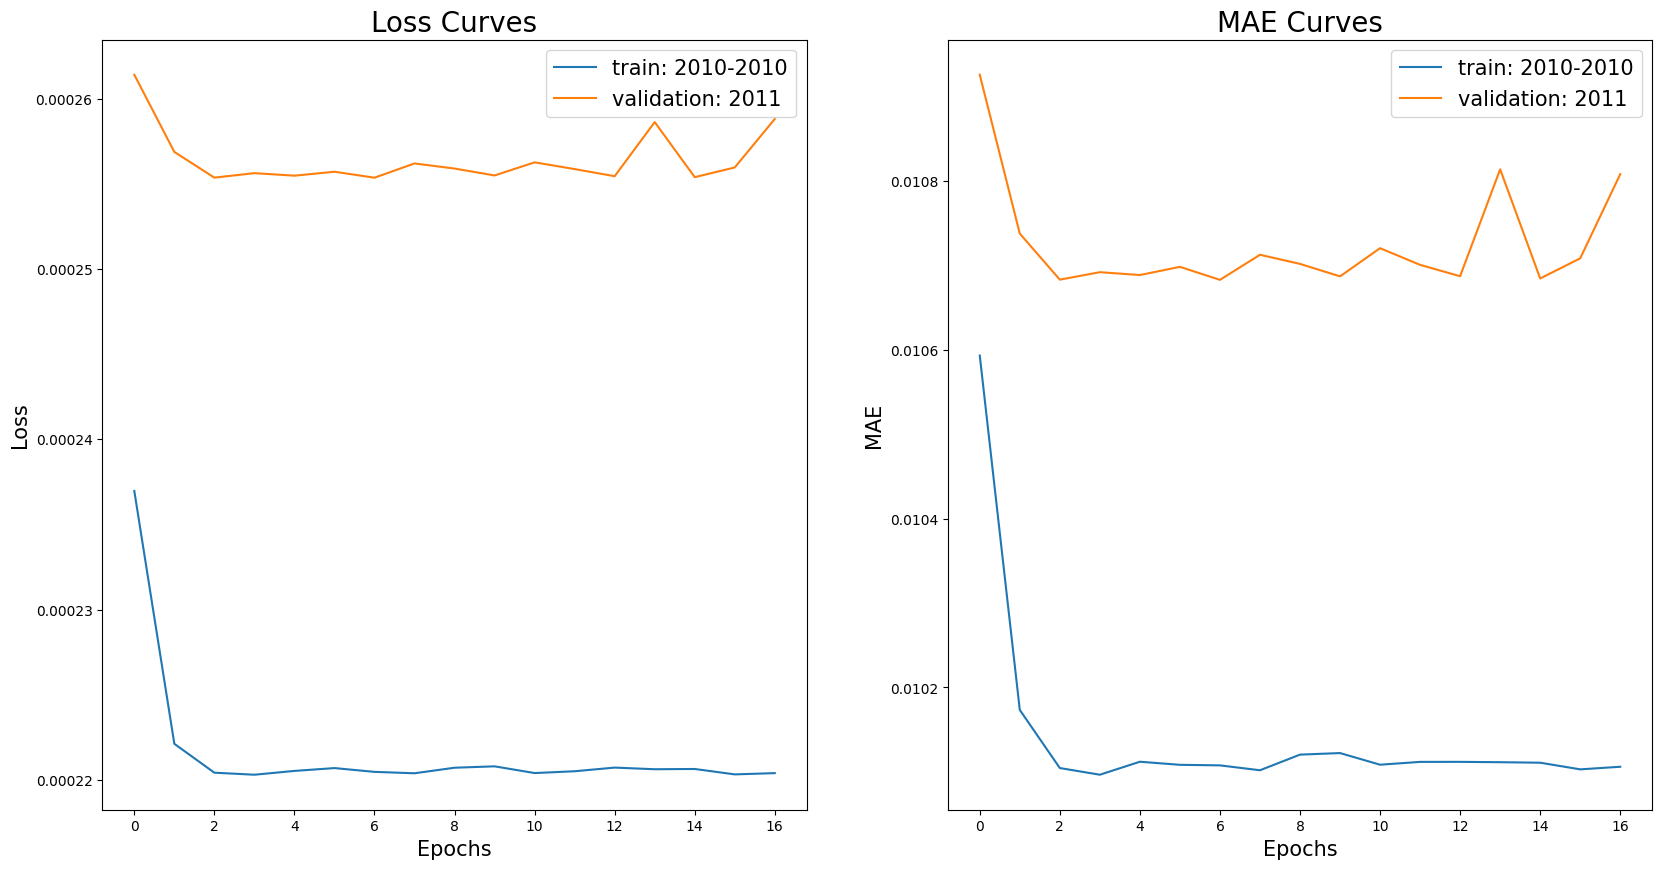

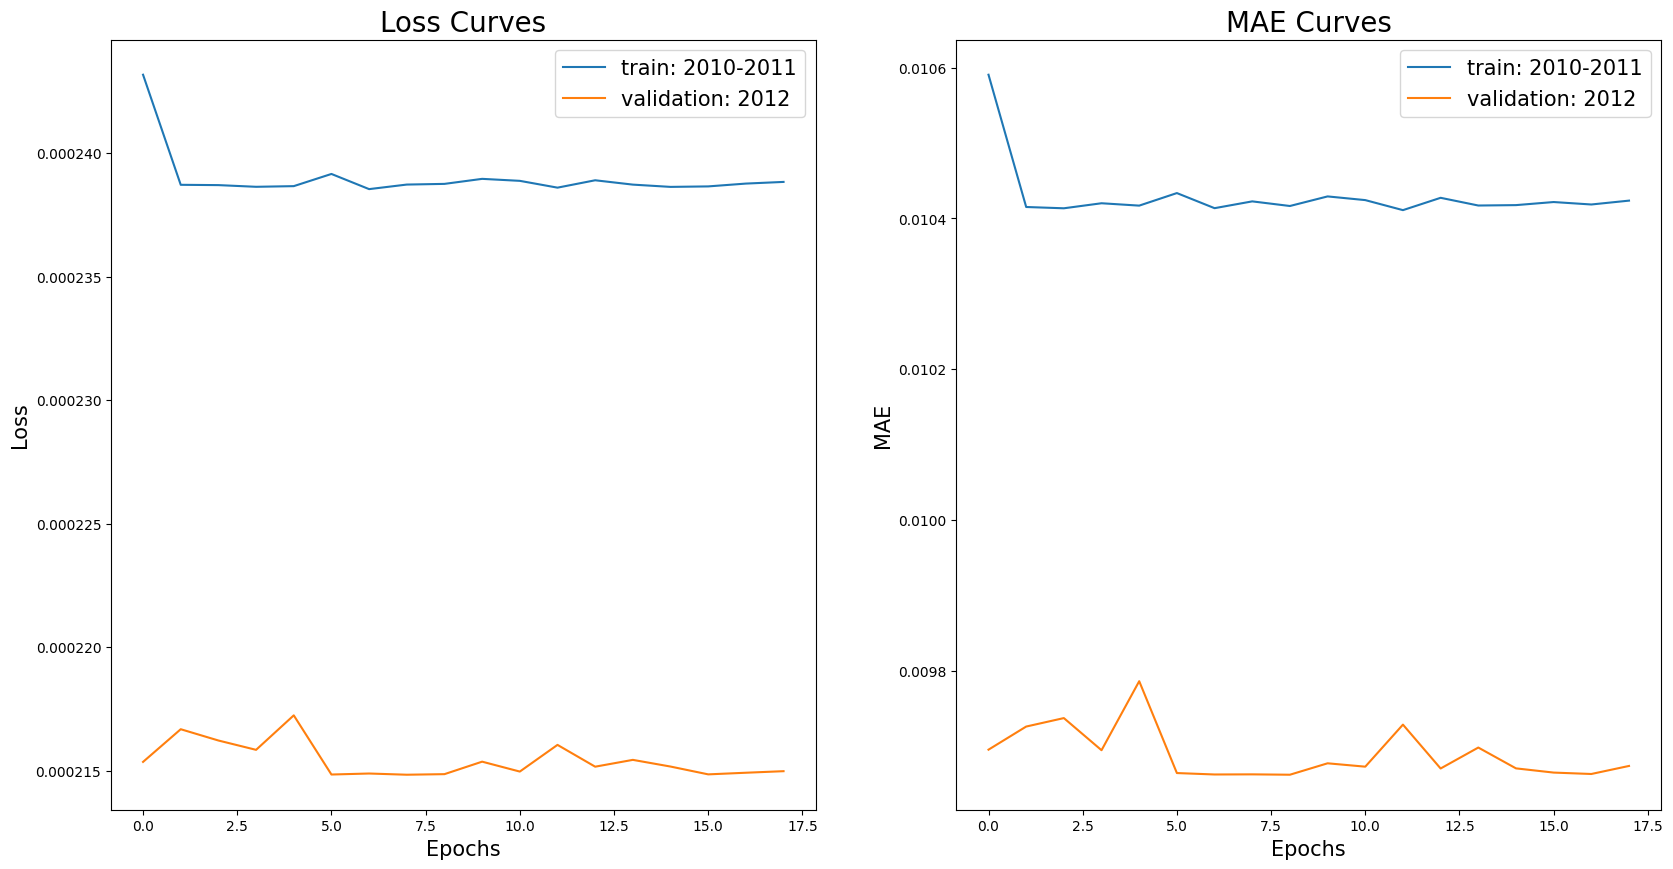

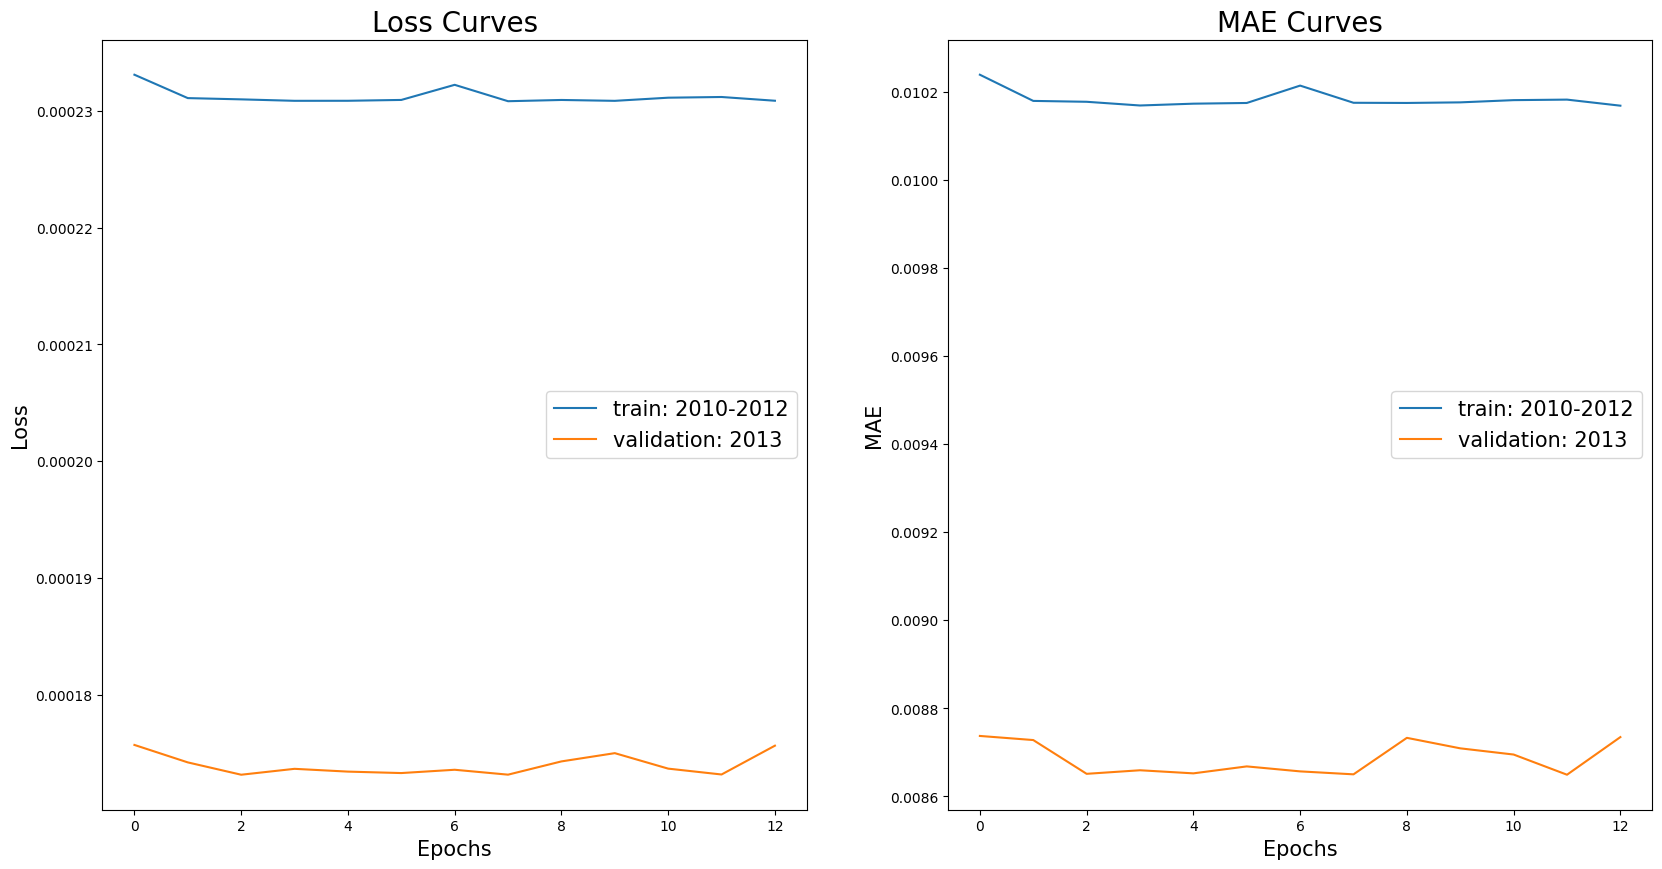

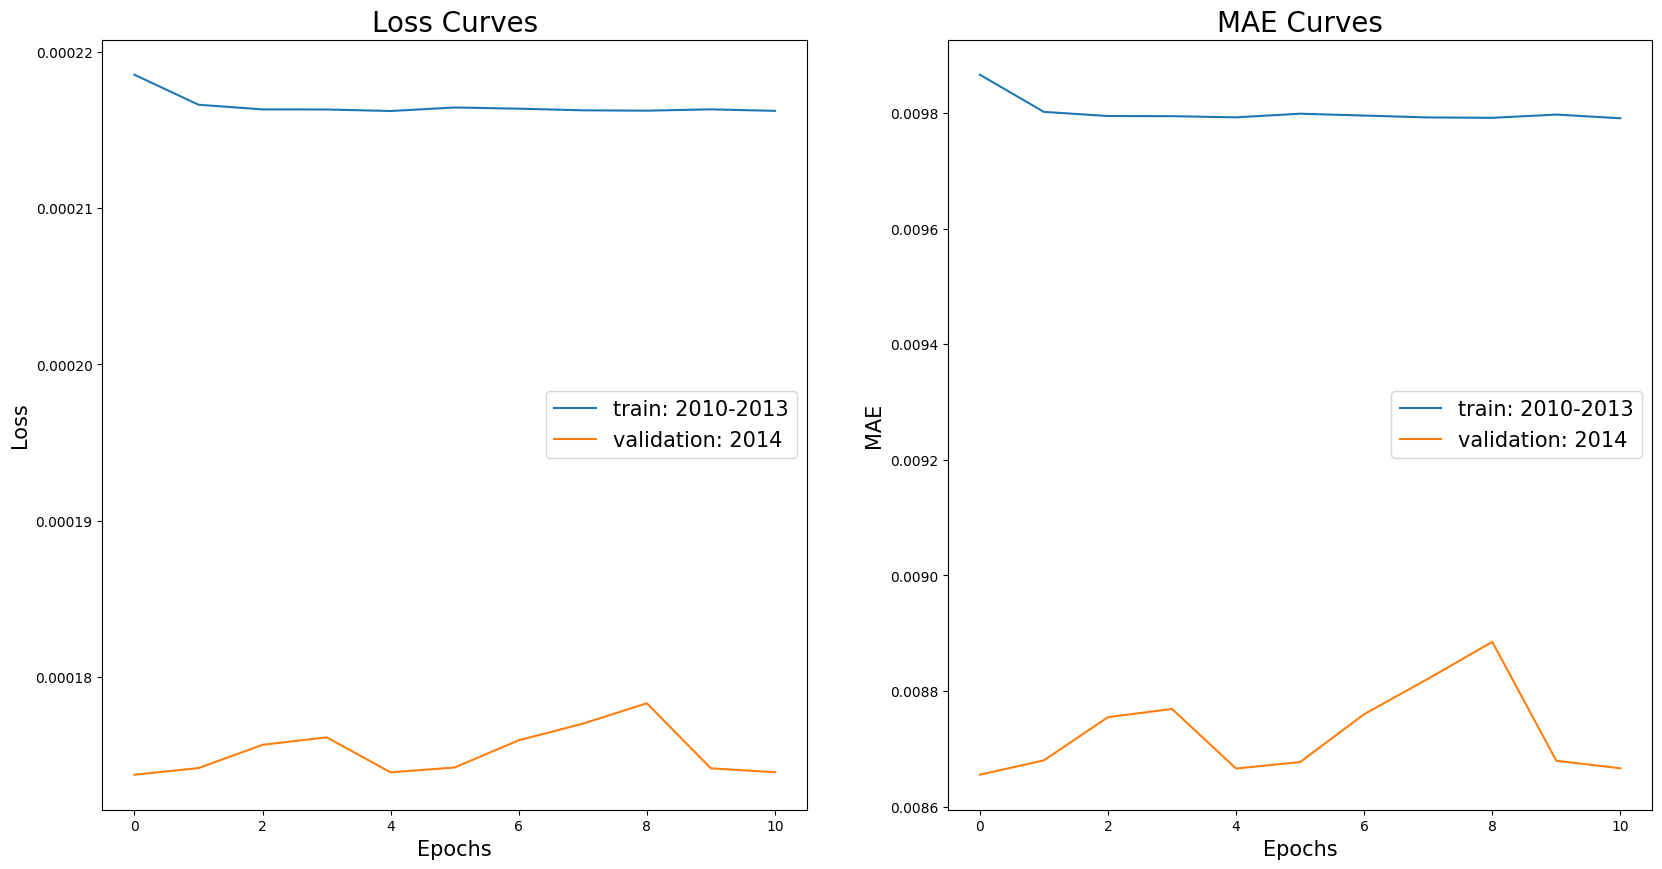

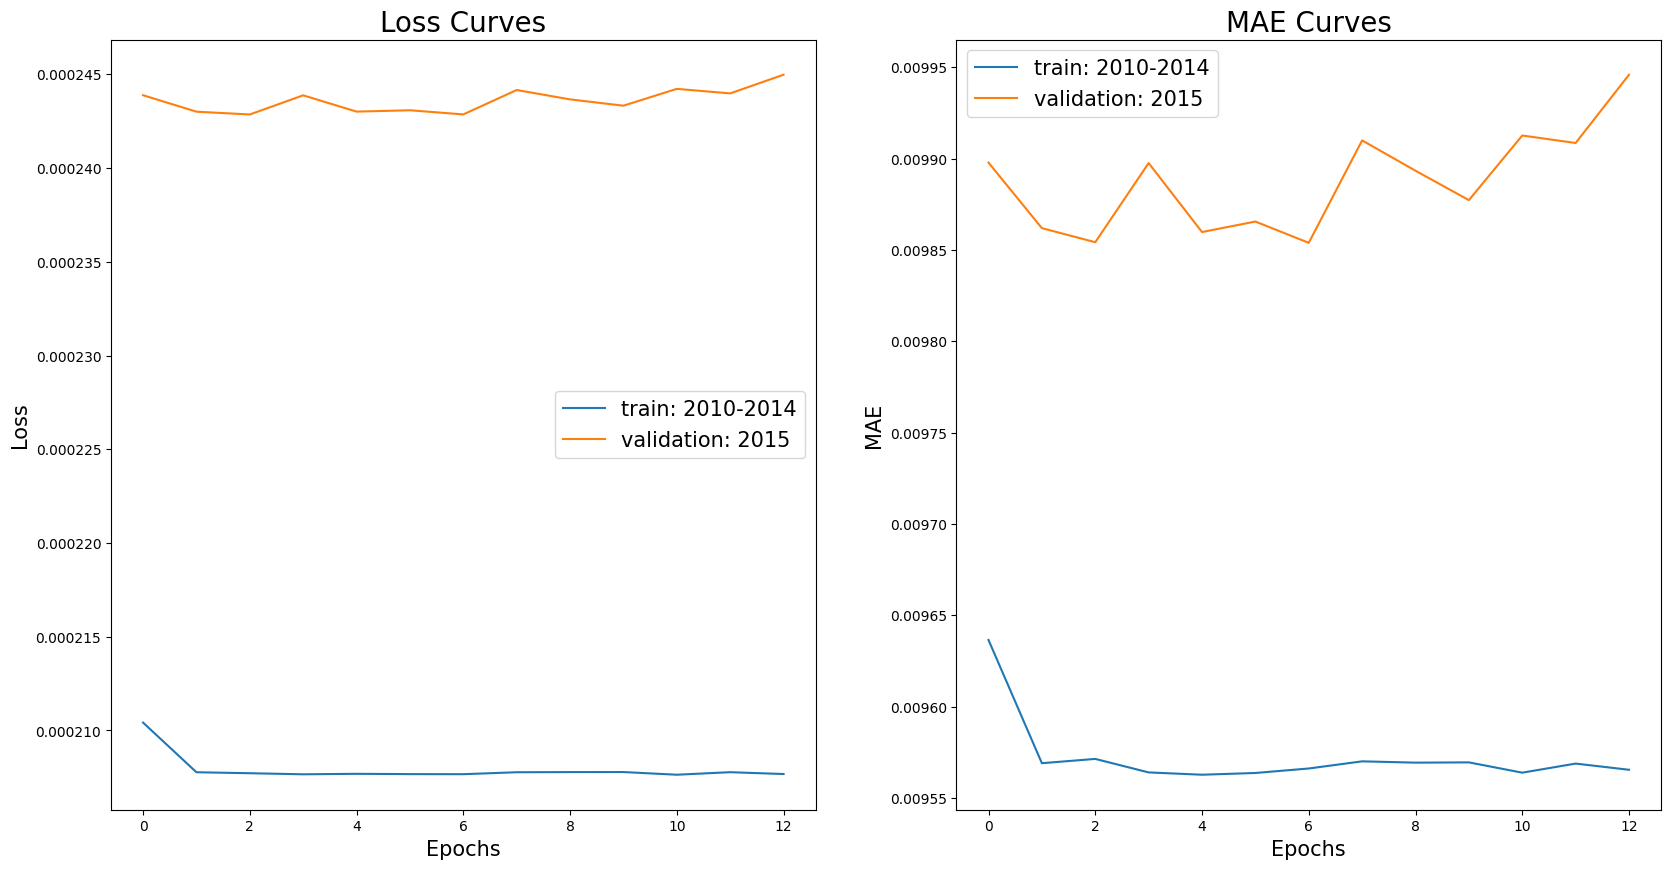

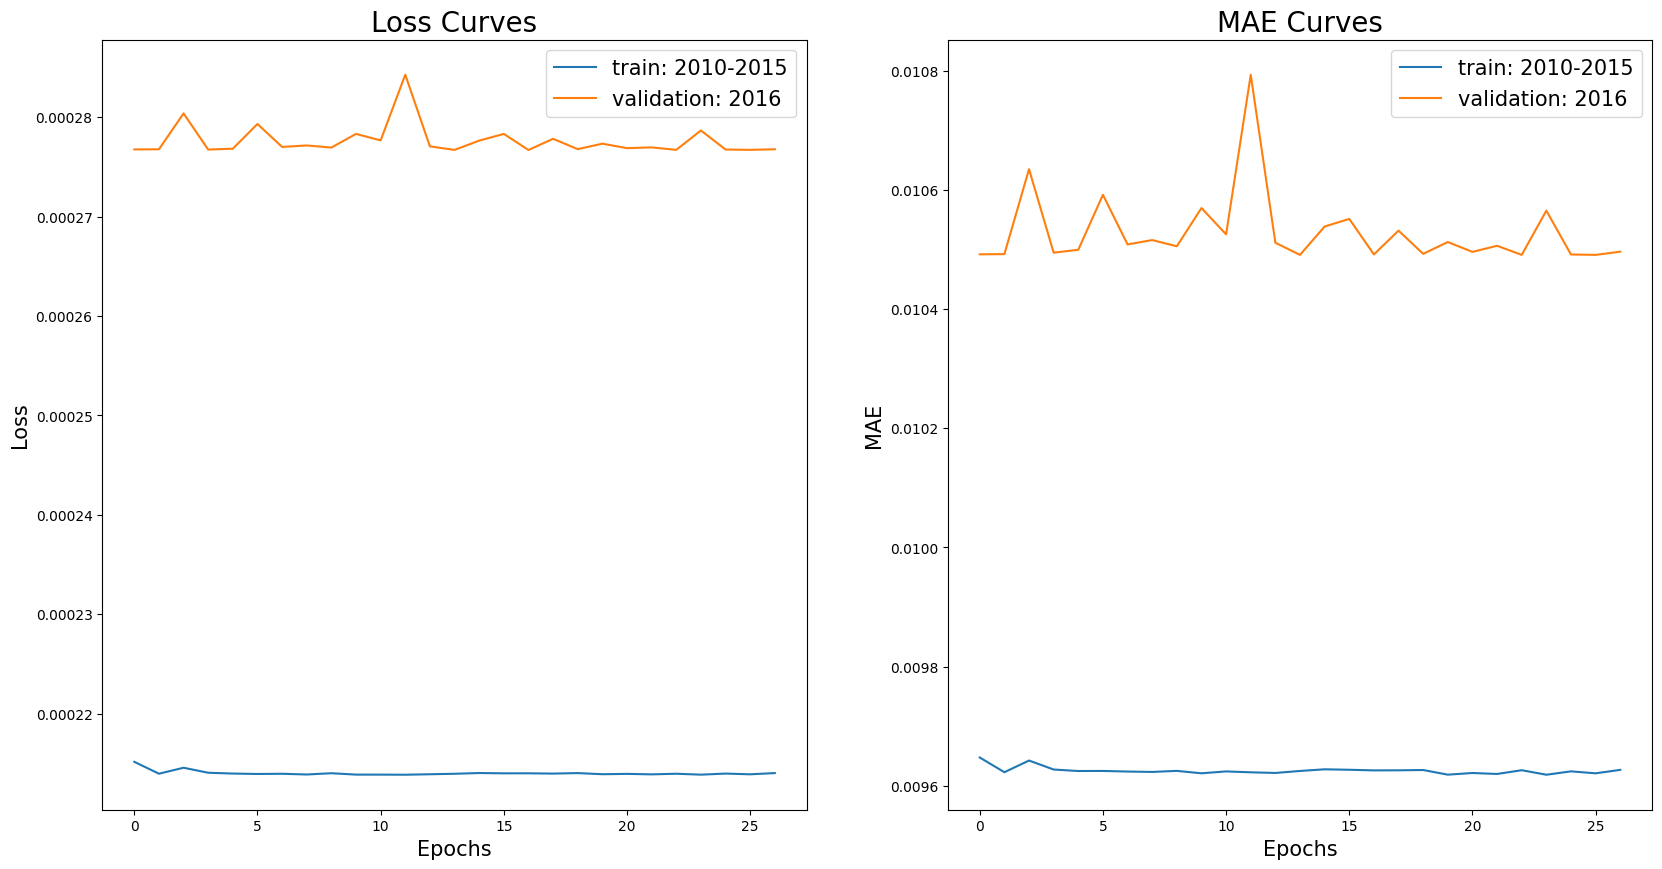

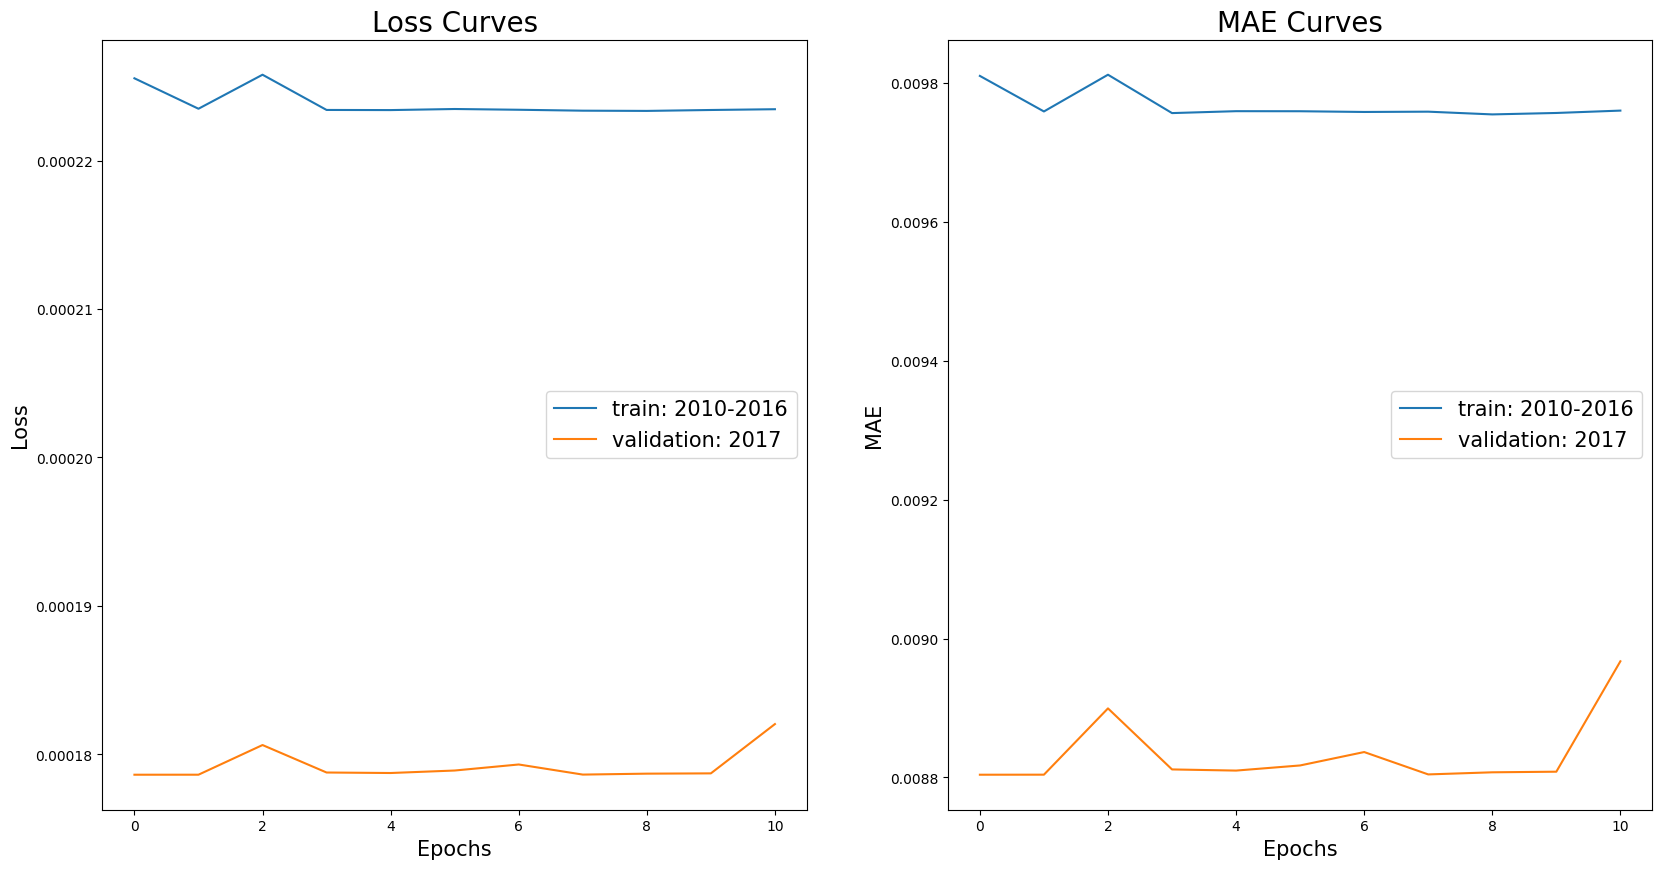

In [21]:
# build models spliting the dataset at different years
start_time = datetime.now()
df_test_all = pd.DataFrame()
n_samples_list = []
for split_years in split_years_list:
    df_test, model, n_samples = build_model_for_one_fold(df, feature_cols, TARGET_COL, DATE_COL, split_years)
    df_test_all = pd.concat([df_test_all, df_test])
    n_samples_list.append(n_samples)
end_time = datetime.now()

In [22]:
print('run time ', end_time-start_time)

run time  2:06:09.035150


In [23]:
df_test_all

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,sector,...,news flag,velocity,novelty,earnings_flag,guidance_flag,merger_flag,rating_flag,z_news,entities_today,y_pred
503,2012-01-03 00:00:00+00:00,67.374450,68.372319,67.374450,67.854904,12249842.0,0.0,0.0,GE,Industrials,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000086
504,2012-01-04 00:00:00+00:00,67.670155,68.741940,67.559285,68.594109,8921285.0,0.0,0.0,GE,Industrials,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000086
505,2012-01-05 00:00:00+00:00,68.224468,68.741882,67.596184,68.557091,9560730.0,0.0,0.0,GE,Industrials,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000086
506,2012-01-06 00:00:00+00:00,69.222359,69.444105,68.594074,68.926697,10656248.0,0.0,0.0,GE,Industrials,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000086
507,2012-01-09 00:00:00+00:00,69.259304,69.776712,68.594059,69.702797,9804489.0,0.0,0.0,GE,Industrials,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391680,2018-12-20 00:00:00+00:00,18.070000,18.280001,17.459999,17.690001,9096600.0,0.0,0.0,UAA,Consumer Cyclical,...,1,2.0,1.00,0.0,0.0,1.0,0.0,"[0.28532457, -0.67564535, -0.8886598, -0.03112...",[nike],-0.000063
391681,2018-12-21 00:00:00+00:00,17.770000,17.950001,16.850000,16.959999,9401000.0,0.0,0.0,UAA,Consumer Cyclical,...,1,2.0,0.75,1.0,0.0,0.0,0.0,"[0.3655004, -0.40341717, -0.7810211, -0.521143...","[lem, lulu, nike, on]",-0.000063
391682,2018-12-24 00:00:00+00:00,16.740000,17.360001,16.570000,16.750000,2688600.0,0.0,0.0,UAA,Consumer Cyclical,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000063
391683,2018-12-26 00:00:00+00:00,16.790001,17.840000,16.520000,17.820000,3966400.0,0.0,0.0,UAA,Consumer Cyclical,...,1,1.0,0.00,0.0,0.0,0.0,0.0,"[-0.1646266, 0.09255396, -1.3083193, 0.8662855...",[],-0.000063


In [24]:
df_test_all[feature_cols+['y_pred']].describe()

,spy_r1,o2c_return,excess_return,VIX_Close,VIX_z,spread_z,dollar_volume,adv_dollar,next_day_excess_return,y_pred
count,306778.000000,306778.000000,306778.000000,306778.000000,306778.000000,306778.000000,3.067780e+05,3.067780e+05,3.067780e+05,306778.000000
mean,0.000497,0.000166,-0.000005,15.172842,-0.195181,-0.539664,2.110375e+08,2.099809e+08,-4.089619e-07,-0.000044
std,0.008091,0.016138,0.014590,3.938324,1.023478,0.977998,2.846556e+08,2.440581e+08,1.457098e-02,0.000142
min,-0.042107,-0.257429,-0.259852,9.140000,-1.977403,-3.000000,0.000000e+00,3.363320e+04,-2.598523e-01,-0.003021
25%,-0.003010,-0.007194,-0.006411,12.510000,-0.918625,-1.049149,7.006311e+07,7.961585e+07,-6.397486e-03,-0.000086
50%,0.000530,0.000254,-0.000081,14.200000,-0.466894,-0.291086,1.340950e+08,1.420616e+08,-7.795764e-05,-0.000063
75%,0.004783,0.007609,0.006278,16.910000,0.262467,0.203980,2.535657e+08,2.566646e+08,6.274904e-03,0.000099
max,0.050525,0.449889,0.448292,40.740002,3.000000,1.215949,1.289610e+10,5.058929e+09,4.482920e-01,0.000155


In [25]:
df_test_all[feature_cols+['y_pred']]

,spy_r1,o2c_return,excess_return,VIX_Close,VIX_z,spread_z,dollar_volume,adv_dollar,next_day_excess_return,y_pred
503,0.015936,0.007131,0.009166,22.969999,-0.154233,-0.770629,8.312119e+08,9.425115e+08,0.009723,-0.000086
504,0.001569,0.013654,0.009723,22.219999,-0.249174,0.567158,6.119476e+08,9.347037e+08,-0.003234,-0.000086
505,0.002663,0.004875,-0.003234,21.480000,-0.342961,0.849611,6.554558e+08,9.144695e+08,-0.000449,-0.000086
506,-0.002577,-0.004271,-0.000449,20.629999,-0.449838,-0.085839,7.345000e+08,9.094401e+08,0.006247,-0.000086
507,0.002427,0.006403,0.006247,21.070000,-0.397933,0.736531,6.834003e+08,8.939534e+08,-0.013246,-0.000086
...,...,...,...,...,...,...,...,...,...,...
391680,-0.016278,-0.021029,-0.010263,28.379999,2.598611,-0.959731,1.609189e+08,1.431048e+08,-0.021103,-0.000063
391681,-0.020489,-0.045583,-0.021103,30.110001,2.909232,-1.431262,1.594410e+08,1.472916e+08,0.020259,-0.000063
391682,-0.026423,0.000597,0.020259,36.070000,3.000000,-1.314891,4.503405e+07,1.477448e+08,0.018078,-0.000063
391683,0.050525,0.061346,0.018078,30.410000,2.812017,-0.726785,7.068125e+07,1.478580e+08,-0.003903,-0.000063


# Write Files

In [28]:
df_test_all.to_csv('/kaggle/working/price_model_test_predicted.csv')

In [29]:
df_test_all.to_pickle('/kaggle/working/price_model_test_predicted.pkl')

In [30]:
# Save the price model 
model.save("/kaggle/working/price_model.keras")

In [31]:
import kagglehub
handle = "rocklaura/multimodal-eq-sizing_norm_final"
local_dataset_dir = "/kaggle/working/"
current_datetime = datetime.now().isoformat()
kagglehub.dataset_upload(handle, local_dataset_dir, version_notes=current_datetime)

Uploading Dataset https://www.kaggle.com/datasets/rocklaura/multimodal-eq-sizing_norm_final ...
More than 50 files detected, creating a zip archive...
Starting upload for file /tmp/tmpdqykeq8b/archive.zip


Uploading: 100%|██████████| 2.33G/2.33G [00:53<00:00, 43.4MB/s] 

Upload successful: /tmp/tmpdqykeq8b/archive.zip (2GB)


Your dataset instance has been created.
Files are being processed...
See at: https://www.kaggle.com/datasets/rocklaura/multimodal-eq-sizing_norm_final


In [32]:
!rm -rf /kaggle/working/multimodal-eq-sizing